# Motivation

This notebook explore the small basal group found using the 98 TFs genes discovered using the selective edge pruning method

In [1]:
%load_ext autoreload
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import os
import sys

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import multiprocess as mp


# own libraries
sys.path.append('/Users/vlad/Developer/York/iNet_v2/src/')

from NetworkAnalysis.ExperimentSet import ExperimentSet
from NetworkAnalysis import GraphHelper as gh
from NetworkAnalysis.utilities import clustering as cs
from NetworkAnalysis.utilities import sankey_consensus_plot as sky
from NetworkAnalysis.utilities.helpers import save_fig, survival_plot
from NetworkAnalysis.GraphToolExp import GraphToolExperiment as GtExp
from NetworkAnalysis.dea import dea
from NetworkAnalysis.dea import helpers as dea_hp
from NetworkAnalysis.dea import gsea as gsea_hp
sys.path.append(os.path.dirname("../../src"))
# Gsea libraries

pio.templates.default = "ggplot2"

pool = mp.Pool(mp.cpu_count())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
results_path = "../../results/exp/"
data_base = "../../data/"
base_path = "../../results/"
exp_folder_tumour = "network_I/tum/"  # "/integration_v2.1/ - path from iNET
exp_folder_h42_ctrl = "network_I/healthyControls/"
dea_path = f"{data_base}/non_cancerous/dea/"
dea_path_tum = f"{data_base}/tumour/sel_pruning/dea/"  # this doesn't havel FC
dea_path_tum_fc = f"{data_base}/tumour/sel_pruning/dea/logFC/"


figures_path = "./smallBasal/"

vu_output = pd.read_csv(
    f"{data_base}/metadata/VU_clustering_v3.tsv", sep="\t", index_col="Sample")

lund_cell_sig = pd.read_csv(f"{data_base}/metadata/lund_cell_signatures.csv")

tcga_mutations_df = pd.read_csv(f"{data_base}/tumour/mutations_tcga.csv")
tcga_mutations_df = tcga_mutations_df[tcga_mutations_df["count"] != 0].set_index(
    "gene")

tcga_metadata = pd.read_csv(
    f"{data_base}/tumour/TCGA_metadata.tsv", sep="\t", index_col="Sample")

tum_tpms = pd.read_csv(
    f"{data_base}/tumour/TPMs_selected_genes_v3_13k_gc42.tsv", sep="\t", index_col="genes")
tum_tpms_v4 = pd.read_csv(
    f"{data_base}/tumour/tum_TPMs_selected_genes_gc42_all_v4.tsv", sep="\t", index_col="genes")

# Healthy and metadata
healthy_metadata = pd.read_csv(f"{data_base}/non_cancerous/healthy_bladder_metadata.tsv",
                               sep="\t", index_col="Sample").drop(index=["Y2796_P0"])
healthy_metadata["sample_prcsd"] = healthy_metadata.index.str.replace("-", "_")

healthy_tpm = pd.read_csv(
    f"{data_base}/non_cancerous/healthy_data_all_gc42_v4.tsv", sep="\t", index_col="gene")
remap_col = {}
for col in healthy_tpm.columns:
    remap_col[col] = col.replace("-", "_")
healthy_tpm = healthy_tpm.rename(columns=remap_col)

# tf list
tf_path = f"{data_base}/metadata/TF_names_v_1.01.txt"
if os.path.exists(tf_path):
    tf_list = np.genfromtxt(fname=tf_path, delimiter="\t",
                            skip_header=1, dtype="str")

In [3]:
sel_tfs = pd.read_csv(f"{data_base}/tf_ctrl.csv", index_col="gene")
sel_tfs["tum_mean_expression"] = tum_tpms_v4.loc[sel_tfs.index].mean(axis=1)
sel_tfs["tum_median_expression"] = tum_tpms_v4.loc[sel_tfs.index].median(
    axis=1)
sel_tfs["tum_std_expression"] = tum_tpms_v4.loc[sel_tfs.index].std(axis=1)
sel_tfs["tum_var_expression"] = tum_tpms_v4.loc[sel_tfs.index].var(axis=1)

## Calculate Lund Scores

Adapted version from the [plotFunction](https://github.com/LundBladderCancerGroup/LundTaxonomy2023Classifier/blob/main/R/plotting_function.R) from LundTaxonomy2023Classifier

In [4]:
def compute_signatures(raw_tpms: pd.DataFrame, signatures_dict, norm=True):
    """
    Process gene expression data to calculate gene signature scores and order samples.

    Parameters:
    - tpm_df: DataFrame of normalized gene expression values (genes as rows, samples as columns).
    - signatures_dict: Dictionary where keys are signature names (e.g., "Late_CC") and values are lists of genes.
    - norm: Boolean, whether to normalize data (default: True).

    Returns:
    - DataFrame where each column is a calculated score (late/early, circuit, ERBB, BaSq, immune, stromal) for each sample.
    """

    tpm_df = np.log2(raw_tpms + 1)

    # Normalize data if specified
    if norm:
        tpm_df = (tpm_df - tpm_df.mean()) / tpm_df.std()

    # Calculate specific scores
    # Late and Early cell cycle
    late_genes = signatures_dict.get("Late_Cell_Cycle", [])
    early_genes = signatures_dict.get("Early_Cell_Cycle", [])
    late_score = (
        tpm_df.loc[tpm_df.index.isin(late_genes)].median(axis=0)
        if not tpm_df.loc[tpm_df.index.isin(late_genes)].empty
        else pd.Series(np.nan, index=tpm_df.columns)
    )
    early_score = (
        tpm_df.loc[tpm_df.index.isin(early_genes)].median(axis=0)
        if not tpm_df.loc[tpm_df.index.isin(early_genes)].empty
        else pd.Series(np.nan, index=tpm_df.columns)
    )
    late_early_score = late_score - early_score

    # Circuit score
    circuit_genes = signatures_dict.get("Circuit", [])
    if all(gene in tpm_df.index for gene in circuit_genes):
        circuit_score = tpm_df.loc["RB1"] + tpm_df.loc["FGFR3"] + \
            tpm_df.loc["CCND1"] - (tpm_df.loc["E2F3"] + tpm_df.loc["CDKN2A"])
    else:
        circuit_score = pd.Series(np.nan, index=tpm_df.columns)

    # ERBB score
    erbb_genes = signatures_dict.get("ERBB", [])
    if all(gene in tpm_df.index for gene in erbb_genes):
        erbb_score = tpm_df.loc["EGFR"] - \
            (tpm_df.loc["ERBB2"] + tpm_df.loc["ERBB3"])
    else:
        erbb_score = pd.Series(np.nan, index=tpm_df.columns)

    # BaSq ratio
    basq_genes = signatures_dict.get("BaSq", [])
    if all(gene in tpm_df.index for gene in basq_genes):
        basq_ratio = tpm_df.loc["KRT5"] + tpm_df.loc["KRT14"] + \
            tpm_df.loc["FOXA1"] - tpm_df.loc["GATA3"]
    else:
        basq_ratio = pd.Series(np.nan, index=tpm_df.columns)

    # Immune score (Immune141_UP)
    immune_genes = signatures_dict.get("Immune141_UP", [])
    immune_score = (
        tpm_df.loc[tpm_df.index.isin(immune_genes)].median(axis=0)
        if not tpm_df.loc[tpm_df.index.isin(immune_genes)].empty
        else pd.Series(np.nan, index=tpm_df.columns)
    )

    # Stromal score (Stromal141_UP)
    stromal_genes = signatures_dict.get("Stromal141_UP", [])
    stromal_score = (
        tpm_df.loc[tpm_df.index.isin(stromal_genes)].median(axis=0)
        if not tpm_df.loc[tpm_df.index.isin(stromal_genes)].empty
        else pd.Series(np.nan, index=tpm_df.columns)
    )
    # Create a DataFrame with all calculated scores as columns
    scores_df = pd.DataFrame(
        {
            "late_early_score": late_early_score,
            "circuit_score": circuit_score,
            "erbb_score": erbb_score,
            "basq_ratio": basq_ratio,
            "immune_score": immune_score,
            "stromal_score": stromal_score,
        }
    )

    # Additional gene expression
    additional_signatures = ["UroDiff", "UPKs",
                             "Adhesion", "MYC", "ScNe", "BaSq", "ERBB"]
    for val in additional_signatures:
        genes = signatures_dict.get(val, [])
        scores_df = pd.concat([scores_df, tpm_df.loc[genes].T], axis=1)

    return scores_df

In [5]:
# Process Lund cell signatures - most of this are taken from the signatures object or the x
lund_cell_sig_df = pd.read_csv(
    f"{data_base}/metadata/lund_cell_signatures.csv")
lund_cell_sig_df["Signature"] = lund_cell_sig_df["Signature"].str.replace(
    ".", "")
lund_signatures = {}
for val in lund_cell_sig_df["Signature"].unique():
    lund_signatures[val] = list(
        lund_cell_sig_df.loc[lund_cell_sig_df["Signature"] == val]["genes"])

lund_signatures["Early_Cell_Cycle"] = lund_signatures["early_cell_cycle"]
lund_signatures.pop("early_cell_cycle")

lund_signatures["UroDiff"] = ["PPARG", "FOXA1", "GATA3", "ELF3"]

lund_signatures["UPKs"] = ["UPK1A", "UPK1B", "UPK2", "UPK3A", "KRT20"]
lund_signatures["Circuit"] = ["FGFR3", "CCND1", "E2F3", "RB1", "CDKN2A"]
lund_signatures["BaSq"] = ["KRT5", "KRT14", "FOXA1", "GATA3"]
lund_signatures["Adhesion"] = ["EPCAM", "CDH1", "CDH3"]
lund_signatures["MYC"] = ["MYCL", "MYCN", "MYC"]
lund_signatures["ERBB"] = ["EGFR", "ERBB2", "ERBB3"]
lund_signatures["ScNe"] = ["CHGA", "SYP", "ENO2"]

lund_signatures.keys()

lund_sig_df = compute_signatures(
    tum_tpms_v4, signatures_dict=lund_signatures, norm=False)

## Importing Morpheus

In [6]:
morpheus_path = "selective_edge_pruning/morpheus/"

morp_df = pd.read_csv(
    f"{morpheus_path}/15_CS_norm_log2_sel_tfs_no_outliers.gct", sep="\t", skiprows=2)
columns = morp_df["id"]
morp_df = morp_df.drop(columns=["Notes"]).transpose()
morp_df.columns = columns
morp_df = morp_df.iloc[2:, :]

morp_df["dendrogram_cut"] = morp_df["dendrogram_cut"].astype(float).astype(int)
morp_df["dendrogram_cut"] = morp_df["dendrogram_cut"].astype(int)
morp_df["dendrogram_label"] = morp_df["dendrogram_cut"].replace(
    {3: "mes-like", 4: "large-basal", 5: "small-basal", 13: "large-luminal", 12: "lum-inf"})

keep_clusters = []
# Size of 1%
size_th = round(morp_df.shape[0] * 0.01)
for cluster, size in morp_df["dendrogram_cut"].value_counts().items():
    if size > 5:
        keep_clusters.append(cluster)

# Drop clusters that are smaller than 1% of the cohort size
morp_df = morp_df.loc[morp_df["dendrogram_cut"].isin(keep_clusters)]

In [7]:
# Sankey
morp_df.rename_axis("sample", axis="columns", inplace=True)
reorder_cols = [
    "TCGA408_classifier",
    # "consensus",
    # "Lund2017.subtype",
    "dendrogram_cut",
    "KMeans_labels_6",
    # "Lund2017.subtype",
]
morp_df["dendrogram_cut"] = morp_df["dendrogram_cut"].astype(str)
meta, sky_fig = sky.main(df=morp_df, reorder_cols=reorder_cols,
                         title="MIBC stratification based on the TF from selective edge pruning", retMeta=True)
sky_fig.update_layout(
    title="",
    template="ggplot2",  # "ggplot2", "plotly_white"
    font=dict(size=16),
    # paper_bgcolor="rgba(0,0,0,0)",
)
sky_fig.show()
save_fig(name="sky_sel_tfs", fig=sky_fig,
         base_path=figures_path, width=1200, height=600)
del sky_fig

# Box groups

In [8]:
import pandas as pd
import scipy.stats as stats
from scikit_posthocs import posthoc_dunn
import seaborn as sns


def box_exp_groups(df: pd.DataFrame, genes: list, classifier="consensus", title="", height=1200):

    color_map = {}
    if classifier == "consensus":
        color_map = {"LumP": "#00CC33", "LumNS": "#006600", "LumU": "#0033CC",
                     "Stroma-rich": "#99CC33", "Ba/Sq": "#FF0000", "NE-like": "#CC00FF"}
    figs, titles = [], []
    for gene in genes:
        fig = px.box(df.reset_index(names="sample"), y=gene, x=classifier, points="all",
                     color=classifier, color_discrete_map=color_map, hover_data="sample")
        fig = fig.update_layout(
            title=gene, yaxis_title="TPM", xaxis_title=classifier, title_y=1.0)
        figs.append(fig)
        titles.append(gene)

    num_cols = 3
    subplots_config = {
        "num_cols": num_cols,
        "shared_x": False,
        "shared_y": False,
        "h_spacing": 0.04,
        "v_spacing": 0.08,
        "main_title": title,
        "height": height,
        "width": None,
        "y_title": None,
        "x_title": None,
        "specs": None,
    }
    fig = gh.helper_multiplots(figs, titles, subplots_config)

    return fig


def group_sig_test(
    gene: str,
    df: pd.DataFrame,
    classifier="consensus",
    path='',
):

    kw_stat, kw_p_value = stats.kruskal(
        *[group[gene].values for name, group in df.groupby(classifier)])
    print(f"Kruskal-Wallis test p-value: {kw_p_value}")

    # 240 is blue, 10 is red in HUSL space
    cmap = sns.diverging_palette(240, 10, as_cmap=True)

    # Setup model - note: Welch's ANOVA isn't directly implemented, but you can use ols and specify Welch's method in the ANOVA
    if kw_p_value < 0.05:
        posthoc_results = posthoc_dunn(df, val_col=gene, group_col=classifier)
        plt.figure(figsize=(8, 6))
        sns.heatmap(posthoc_results, annot=True, fmt=".2g", cmap=cmap,
                    center=0.05, cbar_kws={"label": "Adjusted p-value"})
        plt.title(f"{gene}. Heatmap of Dunn's Post-Hoc Test P-Values")
        plt.xlabel("Subgroup")
        plt.ylabel("Subgroup")
        if path != '':
            plt.savefig(f'{path}/{gene}_sig_test.pdf')
        else:
            display(posthoc_results)
            plt.show()
    return posthoc_results


genes_lum = ["MSX2", "HOXB6", "MECOM", "GRHL3", "JRK",
             "BHLHE41", "ZBTB7C", "ZSCAN16", "ZNF224", "ZBTB10"]
genes_basal = ["TP63", "BNC1", "HES2", "ERF", "IRF6", "ZXDB",
               "ZNF750", "ETS1", "MSANTD3", "FOSL1", "KLF6", "KLF16"]

In [9]:
sel_tpms = tum_tpms_v4.loc[sel_tfs.index].T
dmy_df = pd.concat([morp_df[["consensus", "dendrogram_cut",
                   "dendrogram_label"]], sel_tpms], axis=1).dropna()

In [10]:
sel_tpms = tum_tpms_v4.loc[sel_tfs.index].T
dmy_df = pd.concat([morp_df[["consensus", "dendrogram_cut",
                   "dendrogram_label"]], sel_tpms], axis=1).dropna()

remap_labels = {
    'small-basal': "basal_5",
    'large-basal': "basal_4",
    'mes-like': "mes_3",
    'lum-inf': "lum_12",
    'large-luminal': "lum_13",
}
dmy_df['dendrogram_label'].replace(remap_labels, inplace=True)

height, width = 1400, 2000
fig = box_exp_groups(
    dmy_df,
    genes=genes_basal,
    classifier="dendrogram_label",
    height=height,
    title="Expression across Hierarchical cluster.A. Genes that are expressed more in luminal",
)
fig = fig.update_layout(
    title="",
    xaxis=dict(tickfont=dict(size=17)),
    yaxis=dict(tickfont=dict(size=17)),
    font=dict(size=20),
)
fig = fig.update_annotations(font=dict(size=22, color="black"))
# fig.show()

# Survival analysis

In [11]:
from lifelines.statistics import multivariate_logrank_test


def prep_survival(df, cs_model="RawKMeans", label="SBM"):

    colors_net, color_map = px.colors.qualitative.G10 + px.colors.qualitative.D3, {}
    for idx, val in enumerate(df[cs_model].unique()):
        color_map[val] = colors_net[idx]

    df[cs_model] = df[cs_model].astype(str)
    fig = survival_plot(df.drop(columns=[
                        "days_to_last_follow_up", "days_to_death"]), vu_output, classifier=cs_model, color_map=color_map)
    fig = fig.update_layout(
        title="{}. Survival analysis for {}".format(label, cs_model))

    return fig, color_map


def survival_sig(df, model):
    df = df.reset_index().rename(columns={"index": "Sample"}).copy(deep=True)
    classifier = model

    dmy = df[["days_to_last_follow_up", "days_to_death",
              classifier]].replace("--", 0).astype(int)
    dmy["last_contact"] = dmy[["days_to_last_follow_up",
                               "days_to_death"]].max(axis=1).div(30)

    labels = list(df[model].unique())
    dmy = dmy[dmy[classifier].isin(labels)]
    print(labels)

    results = multivariate_logrank_test(
        dmy["last_contact"], dmy[classifier], dmy["days_to_death"])
    display(results.print_summary())
    print("{0:.6f}".format(results.p_value))


# add the survival metadata
morp_df["days_to_last_follow_up"] = tcga_metadata["days_to_last_follow_up"]
morp_df["days_to_death"] = tcga_metadata["days_to_death"]

# Save to TSV
morp_df[["consensus", "TCGA408_classifier", "dendrogram_cut", "dendrogram_label", "KMeans_labels_6"]].to_csv(
    figures_path + "vu_net_1.tsv", sep="\t", index=True
)

In [12]:
cluster_model = "dendrogram_cut"
fig, dendo_color_map = prep_survival(
    morp_df, cs_model=cluster_model, label="CS_15")

fig.update_layout(
    legend=dict(
        orientation="h",
        title="Network subtype",
        yanchor="bottom",
        y=0.9,
        xanchor="center",
        x=0.5,
        bgcolor="rgba(0,0,0,0)",
        font=dict(size=16, color="#003366"),
    ),
    title="",
    xaxis=dict(tickfont=dict(size=20)),
    yaxis=dict(tickfont=dict(size=20)),
    font=dict(size=18),
    height=700,
)
fig.add_annotation(text="Significance p=0.000140", x=29, y=0.92,
                   showarrow=False, font=dict(size=18, color="#003366"))
fig.show()
save_fig(name="survival_sel_tfs_cs", fig=fig,
         base_path=figures_path, width=1000, height=600, margin=0.02)

morp_df[cluster_model] = morp_df[cluster_model].astype(float).astype(int)
survival_sig(morp_df, model=cluster_model)

[3, 4, 5, 12, 13]


<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 4
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          22.78 <0.005     12.80

None

0.000140


In [13]:
morp_df[cluster_model] = morp_df[cluster_model].astype(float).astype(int)
survival_sig(morp_df, model=cluster_model)

[3, 4, 5, 12, 13]


<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 4
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          22.78 <0.005     12.80

None

0.000140


### Tumour purity

In [14]:
morp_df["Immune_score"] = morp_df["Immune_score"].astype(float)
morp_df["ESTIMATE_score"] = morp_df["ESTIMATE_score"].astype(float)
morp_df["Stromal_score"] = morp_df["Stromal_score"].astype(float)
morp_df["IFNG_score"] = vu_output["IFNG_score"].astype(float)
morp_df["infiltration_score"] = vu_output["infiltration_score"].astype(float)

# dmy_df = morp_df[morp_df['KM']]
if 0:
    fig = px.scatter(morp_df, x="ESTIMATE_score", y="Stromal_score",
                     color="dendrogram_label", size="infiltration_score", height=700)
    display(fig)

    fig = px.scatter(morp_df, x="ESTIMATE_score", y="Stromal_score",
                     color="KMeans_labels_6", size="infiltration_score", height=700)
    display(fig)

    fig = px.scatter(morp_df, x="ESTIMATE_score", y="IFNG_score",
                     color="dendrogram_label", size="infiltration_score", height=700)
    display(fig)

## Export Morpheus w/ Lund signatures

In [15]:
r_morph = morp_df.copy(deep=True)
r_morph.index.names = ["Sample"]
r_morph.index = r_morph.index.str.replace("-", ".")

r_morph.to_csv(f"{figures_path}/clustering_sel_pruning_R.tsv",
               sep="\t", index=True)

# pd.read_csv(f"{figures_path}/clustering_sel_pruning", sep="\t", index_col="Sample")

## Display Lund signatures for plits

In [16]:
lund_sig_df = compute_signatures(
    tum_tpms_v4, signatures_dict=lund_signatures, norm=True)

comb_df = pd.concat([morp_df, lund_sig_df], axis=1).dropna()

In [17]:
classifier = "dendrogram_label"  # 'Lund2017.subtype"
figs, titles = [], []
for score in ["late_early_score", "circuit_score", "erbb_score", "basq_ratio", "immune_score", "stromal_score"]:
    fig = px.box(comb_df, y=score, x=classifier,
                 color=classifier, points="all", title=score)
    figs.append(fig)
    titles.append(score)

num_cols = 3
subplots_config = {
    "num_cols": num_cols,
    "shared_x": False,
    "shared_y": False,
    "h_spacing": 0.04,
    "v_spacing": 0.2,
    "main_title": "Lund scores",
    "height": 900,
    "width": None,
    "y_title": None,
    "x_title": None,
    "specs": None,
}
fig = gh.helper_multiplots(figs, titles, subplots_config)
fig = fig.update_layout(
    title="",
    xaxis=dict(tickfont=dict(size=18)),
    yaxis=dict(tickfont=dict(size=18)),
    font=dict(size=18),
)
fig.update_annotations(font=dict(size=22, color="black"))
save_fig(f"lundScores_{classifier}", fig=fig, width=1400,
         height=900, base_path=figures_path, margin=0.02)

### Significance tests

In [18]:
import pandas as pd
import scipy.stats as stats
from scikit_posthocs import posthoc_dunn
import seaborn as sns


def circuit_sig_test(
    col: str,
    df: pd.DataFrame,
    classifier="consensus",
):

    kw_stat, kw_p_value = stats.kruskal(
        *[group[col].values for name, group in df.groupby(classifier)])
    print(f"Kruskal-Wallis test p-value: {kw_p_value}")

    # 240 is blue, 10 is red in HUSL space
    cmap = sns.diverging_palette(240, 10, as_cmap=True)

    # Setup model - note: Welch's ANOVA isn't directly implemented, but you can use ols and specify Welch's method in the ANOVA
    if kw_p_value < 0.05:
        posthoc_results = posthoc_dunn(df, val_col=col, group_col=classifier)
        plt.figure(figsize=(8, 6))
        sns.heatmap(posthoc_results, annot=True, fmt=".2g", cmap=cmap,
                    center=0.05, cbar_kws={"label": "Adjusted p-value"})
        plt.title(f"{col}. Heatmap of Dunn's Post-Hoc Test P-Values")
        plt.xlabel("Group")
        plt.ylabel("Group")
        plt.show()
    return posthoc_results

Kruskal-Wallis test p-value: 7.657717816580935e-17


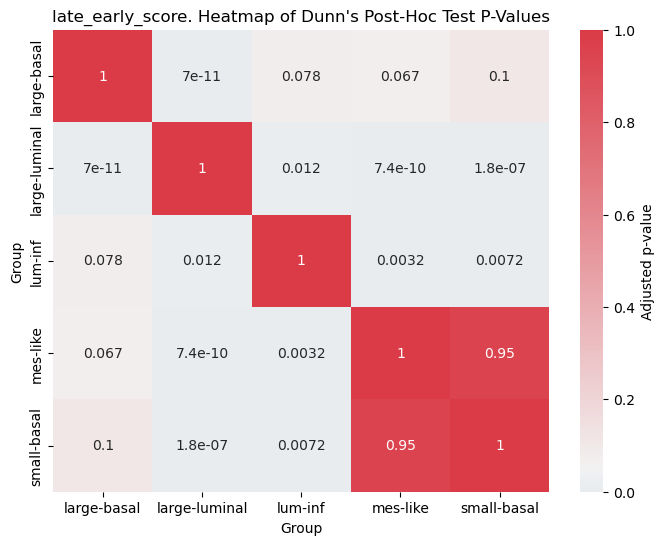

large-basal  large-luminal   lum-inf  mes-like  small-basal
large-basal       1.000000            NaN  0.077638  0.067258     0.102210
large-luminal          NaN            1.0       NaN       NaN          NaN
lum-inf           0.077638            NaN  1.000000       NaN          NaN
mes-like          0.067258            NaN       NaN  1.000000     0.949021
small-basal       0.102210            NaN       NaN  0.949021     1.000000

In [19]:
# classifier, gene = 'dendrogram_label', 'FOSL1'
classifier, col = "dendrogram_label", "circuit_score"

for score in ["late_early_score", "circuit_score", "erbb_score", "basq_ratio", "immune_score", "stromal_score"]:
    result = circuit_sig_test(col=score, classifier=classifier, df=comb_df)
    display(result[result >= 0.05])
    break

# DEA

In [20]:
f_mes_small_basal = "logFC_Mes-like_vs_Small_BaSq_v1_gc42_vulcano.tsv"
f_mes_large = "logFC_Mes-like_vs_Large_BaSq_v1_gc42_vulcano.tsv"

f_mes_lumInf = "logFC_Mes-like_vs_LumInf_v1_gc42_vulcano.tsv"
f_mes_large_lump = "logFC_Mes-like_vs_LumP_v1_gc42_vulcano.tsv"

f_small_large_basla = "logFC_Large_BaSq_vs_Small_BaSq_v1_gc42_vulcano.tsv"

f_large_basal_large_lump = "logFC_Large_BaSq_vs_LumP_v1_gc42_vulcano.tsv"
f_small_basal_large_lump = "logFC_Small_BaSq_vs_LumP_v1_gc42_vulcano.tsv"

f_large_basal_lum_inf = "logFC_Large_BaSq_vs_LumInf_v1_gc42_vulcano.tsv"
f_small_basal_lum_inf = "logFC_Small_BaSq_vs_LumInf_v1_gc42_vulcano.tsv"

# Run configurationw
runs_config = {
    "smallBasal": {"file_2": f_mes_small_basal, "file_1": f_small_large_basla, "ref_x": "min", "ref_y": "min"},
    "largeBasal": {"file_1": f_large_basal_lum_inf, "file_2": f_large_basal_large_lump, "ref_x": "max", "ref_y": "max"},
    "mesLike": {"file_1": f_mes_large_lump, "file_2": f_mes_lumInf, "ref_x": "max", "ref_y": "max"},
    "lumInf": {"file_1": f_large_basal_lum_inf, "file_2": f_small_basal_lum_inf, "ref_x": "min", "ref_y": "min"},
    "largeLuminal": {"file_1": f_large_basal_large_lump, "file_2": f_small_basal_large_lump, "ref_x": "min", "ref_y": "min"},
    "smallBasal_2": {"file_1": f_small_basal_lum_inf, "file_2": f_small_basal_large_lump, "ref_x": "max", "ref_y": "max"},
    "smallBasal_3": {"file_1": f_small_basal_large_lump, "file_2": f_small_large_basla, "ref_x": "max", "ref_y": "min"},
}

# Processing the added markers
base_path = "/Users/vlad/Developer/York/iNet_v2/data/ref_markers/"
sel_tfs = pd.read_csv(f"{base_path}/tf_ctrl.csv", index_col="gene")
all_markers = pd.read_csv(f"{base_path}/known_markers.tsv", sep="\t")
all_markers = pd.concat([all_markers, pd.Series(
    sel_tfs.index.rename("Selected TF"))], axis=1)

sel_cols = {
    "smallBasal": ["Selected TF", "Squamous Markers", "Basal Markers", "serp", "spr", "Up Reg SCC", "Down Reg SCC", "sb_ifng", "TF Differentiation", "KRT"],
    "largeBasal": [
        "Selected TF",
        "Basal Markers",
        "Squamous Markers",
        "KRT",
        "UPK",
        "serp",
        "spr",
        "cell_diff",
        "ig_fam",
        "sb_ifng",
    ],
    "mesLike": [
        "Luminal Markers",
        "Basal Markers",
        "Squamous Markers",
        "UPK",
        "Macrophages",
        "ig_fam",
        "sb_ifng",
        "Macrophages",
        "Monocytes",
        "B Cells",
        "Lund MES",
    ],
    "largeLuminal": ["Luminal Markers", "Basal Markers", "Neural Differentiation", "Squamous Markers", "UPK", "FGFR Family", "Up Reg SCC", "Down Reg SCC"],
    "smallBasal_2": [
        "Luminal Markers",
        "Basal Markers",
        "Neural Differentiation",
        "Squamous Markers",
        "basal_specific",
        "sb_ifng",
        "basal_specific",
        "Lund MES",
        "FGFR Family",
    ],
    "smallBasal_3": ["Selected TF", "Squamous Markers", "Basal Markers", "serp", "spr", "Up Reg SCC", "Down Reg SCC", "sb_ifng", "TF Differentiation", "KRT"],
}

sel_markers = {}
for key, val in sel_cols.items():
    markers = {}
    for col in val:
        markers[col] = list(all_markers[col].dropna())
    sel_markers[key] = markers

#### Define custom markers to show for each subtype ####
# Basal samples
sel_markers["smallBasal"]["others"] = ["DANCR", "DAPL1", "GATM",
                                       "GSTM3", "MLF1", "SYNGR1", "GSTM1", "MAGI3", "CXCL11", "NFE2L2"]
sel_markers["largeBasal"]["others"] = []
sel_markers["smallBasal_2"]["others"] = ["FGFR3"]
sel_markers["mesLike"]["others"] = ["LY6D", "VSIG2", "ADIRF",
                                    "PSCA", "C10orf99", "AQP3", "DUSP15", "PNK1", "REEP2", "PRAME"]
# Luminal samples
sel_markers["largeLuminal"]["others"] = [
    "KRT6B", "VSIG2", "FAT2", "LY6D", "ANXA8", "SLPI", "CLDN1"]

## Run GSEA

We may need the information to show some of the pathways later

In [21]:
msigdb_hallmarks = "../../data/GSEA/msigDB/h.all.v2023.2.Hs.symbols.gmt"
msigdb_reactome_23 = "../../data/GSEA/msigDB/c2.cp.reactome.v2023.2.Hs.symbols.gmt"
msigdb_reactome_24 = "../../data/GSEA/msigDB/c2.cp.reactome.v2024.1.Hs.symbols.gmt"
msigdb_tf = "../../data/GSEA/msigDB/c3.tft.v2023.2.Hs.symbols.gmt"
msigdb_cancer = "../../data/GSEA/msigDB/c4.all.v2023.2.Hs.symbols.gmt"
msigdb_onco_sig = "../../data/GSEA/msigDB/c6.all.v2023.2.Hs.symbols.gmt"
msigdb_all = "../../data/GSEA/msigDB/msigdb.v2023.2.Hs.symbols.gmt"

databases = {
    "hallmark": {"path": msigdb_hallmarks},
    "reactome_23": {"path": msigdb_reactome_23},
    "reactome": {"path": msigdb_reactome_24},
    # "onco_sig": {"path": msigdb_onco_sig},
    # "can_path": {"path": msigdb_cancer},  # canonical pathway
}

In [22]:
version = "v3"

new_runs = {}
for subtype, config in runs_config.items():
    print(f"##### {subtype} #####")

    if subtype != "smallBasal":
        continue

    # Add the path
    config["path"] = f"{figures_path}/GSEA/{version}/{subtype}/"

    # Run the Pi value - the saved Pi plot is a check for selecting the right quadrant
    config["pi"], config["pi_df"] = gsea_hp.rank_pi_vals(
        subtype, config, dea_path=dea_path_tum_fc, custom_points={"98 TFs": list(sel_tfs.index)}, th=10)

    # Run the GSEA
    gsea_res = gsea_hp.run_gsea(subtype, config, databases=databases)

    # # Merging two dict, requires python >3.5
    new_runs[subtype] = {**config, **gsea_res}

##### smallBasal #####
--> hallmark
--> reactome_23
--> reactome
##### largeBasal #####
##### mesLike #####
##### lumInf #####
##### largeLuminal #####
##### smallBasal_2 #####
##### smallBasal_3 #####


In [23]:
common_paths = {}
for database in databases.keys():
    print(database)
    all_df = pd.DataFrame()
    for key, config in new_runs.items():
        if key == "smallBasal_2" or key != "smallBasal":
            continue
        # print(f"---> {key}")
        df = gsea_hp.process_gsea(config, database=database, th=5000)
        # Saved for all-df
        df["subtype"] = key
        df["database"] = database
        df["Term"] = df["Term"].str.replace(f"{database.upper()}_", "")
        all_df = pd.concat([all_df, df.drop(columns=["Name"])], axis=0)

    common_paths[database] = all_df

hallmark
reactome_23
reactome


## Pi-plot small basal

In [24]:
man_sel_genes = [
    "AKR1B10",
    "ADH7",
    "KRT4",
    "ALDH3A1",
    "DAPL1",
    "PGD",
    "AKR1C1",
    "SLC7A11",
    "CES1",
    "NMRAL2P",
    "SOX2",
    "SOX21",
    "GPX2",
    "KRT13",
    "KRT15",
    "NFE2L2",
    "GRHL3",
    "FAT2",
    "FGFR3",
    "GSTA1",
    "CAPNS2",
    "KRT5",
    "SERPINB13",
    "CLCA2",
    "CLCA4",
    "TMPRSS4",
    "GSTM4",
    # Fom SB
    "CYP4F3",
    "CYP4F11",
    "CYP3A4",
    "CYP2B6",
    'CYP1A1',
    'CYP1B1',
    "AKR1B10",
    "GCLC",
    "HMOX1",
    "NQO1",
    "GPX4",
    'CHAC1',
    "KEAP1",
    "CUL3",
    "NRF2",
]

In [25]:
# Full-pi plot
if 0:
    key = "smallBasal"
    config = runs_config[key]
    used_markers = {**sel_markers[key]}

    # Add the markers for which only the text is shown
    used_markers["man_sel"] = man_sel_genes

    pi, pi_df = gsea_hp.rank_pi_vals(
        key, config, dea_path=dea_path_tum_fc, custom_points=used_markers, show_known_markers=False, th=10)
    pi.update_layout(
        # legend=dict(
        #     title="",
        #     orientation="h",
        #     y=0.95,
        #     x=0.2,  # Small basla
        #     bgcolor="rgba(0,0,0,0)",
        #     font=dict(size=16, color="#003366"),
        # ),
        font=dict(size=16),
        height=1000,
        xaxis_tickfont_size=20,
        yaxis_tickfont_size=20,
        xaxis_title="Basal_5 vs Basal_4 IFNG",
        xaxis_title_font_size=25,
        yaxis_title="Basal_5 vs Basal_3 IFNG",
        yaxis_title_font_size=25,
        yaxis_range=[-40, 12],
        xaxis_range=[-25, 11],
    )
    pi.show()

### Explore GSEA top terms

In [26]:
def isolate_terms(res2d: pd.DataFrame, th=0.8, used_markers={}):

    nes_q_th = res2d["NES"].quantile(th)
    sel_df = res2d[(res2d["NES"] >= nes_q_th) & (
        res2d["FDR q-val"] < 0.05)]  # only sig
    matchedRatio_q_th = sel_df["matched_lead_ratio"].quantile(th)
    sel_df = sel_df[sel_df["matched_lead_ratio"] >= matchedRatio_q_th]

    for _, row in sel_df.iterrows():
        prcsd_term = "-".join(row["Term"].replace("REACTOME_",
                              "").split("_")[:])
        used_markers[prcsd_term] = row["matched_list"]

    return sel_df, used_markers

In [27]:
# to test the enrichment of a pathway

term = "ERBB2"
database = "reactome"  # reactome

config = new_runs["smallBasal"]
res2d = config[database].res2d
test_term = res2d[res2d["Term"].str.contains(
    term)]["Lead_genes_list"].values[0]
used_markers = {f"{term} pathway": test_term}

# Add top matched leading genes
sel_df, tst = isolate_terms(res2d, th=0.9, used_markers=used_markers)
used_markers = {**used_markers, **tst}

kept_terms = [
    "DOWNREGULATION-OF-ERBB2-SIGNALING",
    "NFE2L2-REGULATING-ANTI-OXIDANT-DETOXIFICATION-ENZYMES",
    # 'RORA-ACTIVATES-GENE-EXPRESSION'
    "ACYL-CHAIN-REMODELLING-OF-PC",
    # "SYNTHESIS-OF-PROSTAGLANDINS-PG-AND-THROMBOXANES-TX",
    # "NEGATIVE-REGULATION-OF-TCF-DEPENDENT-SIGNALING-BY-WNT-LIGAND-ANTAGONISTS",
    # "PI3K-EVENTS-IN-ERBB2-SIGNALING",
    # "FORMATION-OF-THE-CORNIFIED-ENVELOPE",
    "TIGHT-JUNCTION-INTERACTIONS",
]
# kept_terms = [
#     "REACTOME_NFE2L2_REGULATING_ANTI_OXIDANT_DETOXIFICATION_ENZYMES",
#     "REACTOME_OTHER_SEMAPHORIN_INTERACTIONS",
#     "REACTOME_ACYL_CHAIN_REMODELLING_OF_PC",
#     "REACTOME_RND1_GTPASE_CYCLE",
#     "REACTOME_NEGATIVE_REGULATION_OF_TCF_DEPENDENT_SIGNALING_BY_WNT_LIGAND_ANTAGONISTS",
#     "REACTOME_FORMATION_OF_THE_CORNIFIED_ENVELOPE",
#     "REACTOME_TIE2_SIGNALING",
#     "REACTOME_ACYL_CHAIN_REMODELLING_OF_PG",
#     "REACTOME_GLUCURONIDATION",
#     "REACTOME_DEFECTIVE_GALNT3_CAUSES_HFTC",
#     "REACTOME_BIOSYNTHESIS_OF_SPECIALIZED_PRORESOLVING_MEDIATORS_SPMS",
# ]
used_markers = {key: value for key,
                value in used_markers.items() if key in kept_terms}

# used_markers = {**used_markers, **sel_markers[key]}

pi, pi_df = gsea_hp.rank_pi_vals(key, config, dea_path=dea_path_tum_fc,
                                 custom_points=used_markers, show_known_markers=False, th=10)

In [28]:
pi.update_layout(
    font=dict(size=16),
    height=1000,
    xaxis_tickfont_size=20,
    yaxis_tickfont_size=20,
    xaxis_title_font_size=25,
    yaxis_title_font_size=25,
    xaxis_title="Basal_5 vs Basal_4 IFNG",
    yaxis_title="Basal_5 vs Basal_3 IFNG",
    xaxis_range=[-65, 35],
    yaxis_range=[-105, 25],
    legend=dict(
        orientation="v",
        title="",
        yanchor="bottom",
        y=0.82,
        xanchor="center",
        x=0.3,
        bgcolor="rgba(0,0,0,0)",
        font=dict(size=15, color="#003366"),
    ),
)
pi.show()

In [29]:
# Config
database = "reactome"
version, subtype = "v3", "smallBasal"

# Data
ranked_gsea = new_runs["smallBasal"][database]
gsea_output_path = f"{figures_path}/GSEA/{version}/{subtype}/"

man_terms = sel_df.sort_values(by=["matched_lead_ratio"])["Term"].values

# prcsd_terms = [f'REACTOME_{term.replace("-", "_")}' for term in kept_terms]

# man_terms = [
#     "REACTOME_SHC1_EVENTS_IN_ERBB2_SIGNALING",
#     "REACTOME_FORMATION_OF_THE_CORNIFIED_ENVELOPE",
#     "REACTOME_NFE2L2_REGULATING_ANTI_OXIDANT_DETOXIFICATION_ENZYMES",
#     "REACTOME_SIGNALING_BY_ERBB2",
#     "REACTOME_DOWNREGULATION_OF_ERBB2_SIGNALING",
# ]
_, _ = gsea_hp.plot_top_gsea(res=ranked_gsea, path=gsea_output_path, num=10,
                             label=f"filt_{subtype}_{database}_4", man_terms=man_terms, database=database)

# NFE2L2

REACTOME_NFE2L2_REGULATING_ANTI_OXIDANT_DETOXIFICATION_ENZYMES

## Explore the relation with the 98 TFs

Kruskal-Wallis test p-value: 1.0575674453791046e-36
Kruskal-Wallis test p-value: 9.711651887358594e-09
Kruskal-Wallis test p-value: 4.987645921579433e-05


['TP63', 'MAFG', 'TCF20']

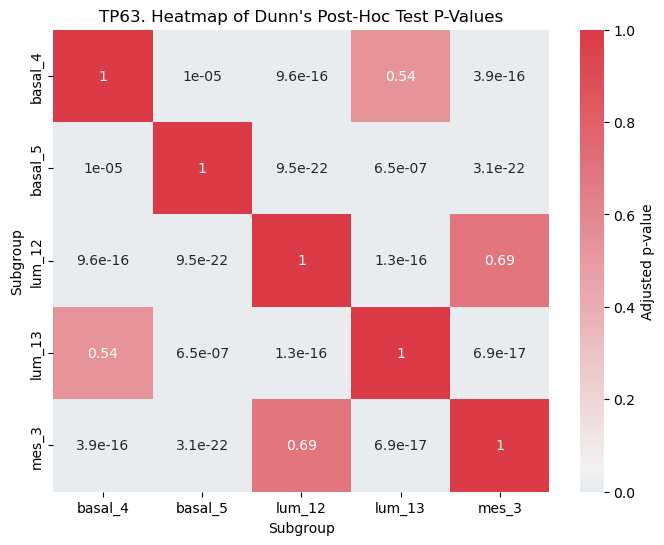

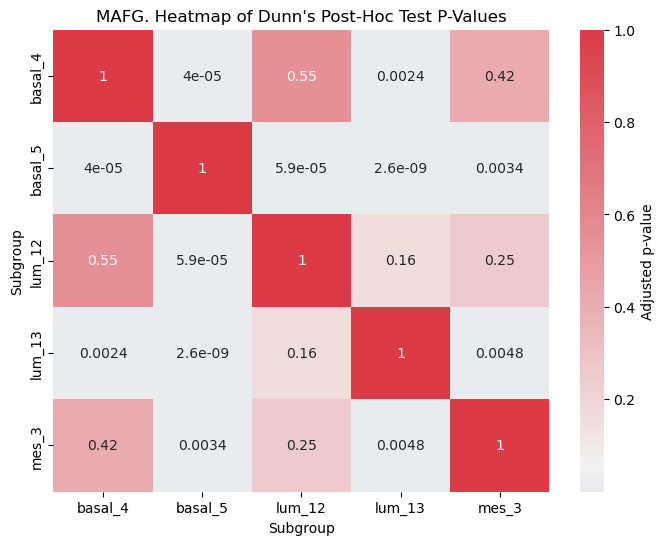

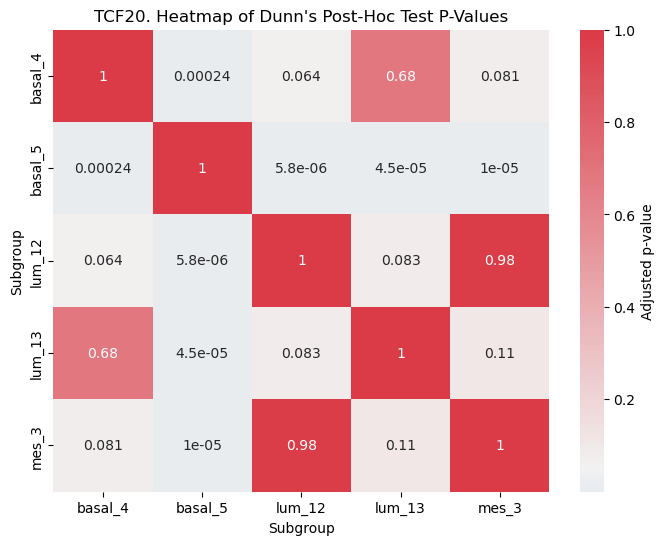

In [30]:
# Load the genes from reactome
gseapy_g = list(sel_df[sel_df["Term"].str.contains(
    "NFE2L2")]["Lead_genes_list"].values[0])
reactome_g = pd.read_csv(
    "../../data/GSEA/REACTOME_NFE2L2_REGULATING_ANTI_OXIDANT_DETOXIFICATION_ENZYMES.v2024.1.Hs.tsv", sep="\t", index_col="STANDARD_NAME"
).rename(columns={"REACTOME_NFE2L2_REGULATING_ANTI_OXIDANT_DETOXIFICATION_ENZYMES": "NFE2L2_REACTOME"})

reactome_g = reactome_g[reactome_g.index.str.contains(
    "GENE_SYMBOLS")].values[0][0].split(",")
nfe2l2_pathway = list(set(gseapy_g) | set(reactome_g))

remap_dendrogram = {
    'small-basal': "basal_5",
    'large-basal': "basal_4",
    'mes-like': "mes_3",
    'lum-inf': "lum_12",
    'large-luminal': "lum_13",
}

# The gene expression that are sig in the small-basal compared with the other
sig_exp_genes = ['KLF5', 'TP63', 'BCL6',
                 'SPEN', 'SP1', 'TCF20', 'MAFG', 'ZNF609']
sig_exp_genes = ['TP63', 'MAFG', 'TCF20']

small_sig_exp = []
for gene in sig_exp_genes:

    sel_tpms = tum_tpms_v4.loc[[gene] + list(sel_tfs.index)].T
    # sel_tpms = tum_tpms_v4.loc[sel_tfs.index].T
    sel_tpms = np.log2(sel_tpms + 1)

    dmy_df = pd.concat(
        [morp_df[['dendrogram_label']], sel_tpms], axis=1).dropna()
    dmy_df = dmy_df.loc[:, ~dmy_df.columns.duplicated()].copy()

    dmy_df['dendrogram_label'].replace(remap_dendrogram, inplace=True)

    results_df = group_sig_test(gene=gene, classifier='dendrogram_label',
                                df=dmy_df, path=f'{figures_path}/sig_tests/').replace(1, 0)
    is_sig_small = (results_df["basal_5"] <= 0.05).values.any()
    if is_sig_small:
        small_sig_exp.append(gene)

small_sig_exp

In [31]:

dmy_df['dendrogram_label'].replace(remap_dendrogram, inplace=True)
fig = box_exp_groups(
    dmy_df,
    genes=sig_exp_genes,
    classifier="dendrogram_label",
    height=height,
    title="Expression across Hierarchical clusters. Genes that are sig expressed in Small Basal",
)
fig = fig.update_layout(
    title="",
    xaxis=dict(tickfont=dict(size=18)),
    yaxis=dict(tickfont=dict(size=18)),
    font=dict(size=18),
)
fig.update_annotations(font=dict(size=22, color="black"))
save_fig(name=f"sig_smallBasal_2", fig=fig,
         base_path=figures_path, width=1400, height=500)

## Significant different for each subtype

In [32]:
# Heatmap of significant genes
if 0:
    dmy_genes = sig_exp_genes + nfe2l2_pathway
    dmy_df = tum_tpms_v4.loc[dmy_genes].T.corr(method='spearman', )
    dmy_df = dmy_df.loc[sig_exp_genes, nfe2l2_pathway]

    fig = px.imshow(dmy_df, color_continuous_scale='sunset',
                    aspect='auto', text_auto=True)
    fig.update_layout(
        xaxis_title='NFE2L2 pathway',
        yaxis_title='Selected from 98 TFs',
        height=700
    )

## Export to Morpheus

In [33]:
dmy_df = np.log2(tum_tpms_v4.loc[nfe2l2_pathway].copy(deep=True) + 1)

sel_metadata = [
    "KMeans_labels_6",
    "consensus",
    "TCGA408_classifier",
    "Lund2017.subtype",
    "ESTIMATE_score",
    "Immune_score",
    "Stromal_score",
    "tumor_stage",
]

dmy_df = pd.concat([vu_output[sel_metadata], dmy_df.T], axis=1).dropna()
dmy_df = pd.concat([morp_df["dendrogram_label"], dmy_df], axis=1)

# Add mutations for the known disruptors of the NFE2L2 pathway
mut_genes = ["NFE2L2", 'KEAP1', 'CUL3', 'KRAS', 'TP53', 'PIK3CA', 'PTEN', ]
sel_mut = tcga_mutations_df.loc[mut_genes].drop(columns=['count']).T

# add the expression of the TFs that are sig different in the small basal
sig_exp_genes = ['KLF5', 'TP63', 'BCL6',
                 'SPEN', 'SP1', 'TCF20', 'MAFG', 'ZNF609']
sel_tpms = tum_tpms_v4.loc[sig_exp_genes].T
dmy_df = pd.concat([sel_mut.loc[dmy_df.index],
                   sel_tpms.loc[dmy_df.index], dmy_df], axis=1).T.fillna("NA")

dmy_df.to_csv(
    f"{figures_path}/morpheus/NFE2L2/v2/mut_allSamples_NFE2L2_v2.tsv", sep="\t")

## Import Morpheus

In [34]:
load_path = f"{figures_path}/morpheus/NFE2L2/v2/"

nfe2_df = pd.read_csv(
    f"{load_path}/allSamples_NFE2L2.gct", sep="\t", skiprows=2)
columns = nfe2_df["id"]
nfe2_df = nfe2_df.drop(columns=["dendrogram_cut"]).transpose()
nfe2_df.columns = columns
nfe2_df = nfe2_df.iloc[2:, :]

nfe2_df.rename(columns={"dendrogram_cut": "NFE2LE_subtype"}, inplace=True)

keep_clusters = []
# Size of 1%
size_th = round(nfe2_df.shape[0] * 0.01)
for cluster, size in nfe2_df["NFE2LE_subtype"].value_counts().items():
    if size > 5:
        keep_clusters.append(cluster)
    else:
        nfe2_df.loc[nfe2_df['NFE2LE_subtype']
                    == cluster, 'NFE2LE_subtype'] = -1

# Drop clusters that are smaller than 1% of the cohort size
# nfe2_df = nfe2_df.loc[nfe2_df["NFE2LE_subtype"].isin(keep_clusters)]

# Sankey
nfe2_df.rename_axis("sample", axis="columns", inplace=True)
reorder_cols = [
    "TCGA408_classifier",
    "dendrogram_label",
    "NFE2LE_subtype",
    "Lund2017.subtype",
    "consensus",
    # "Lund2017.subtype",
]

In [35]:
nfe2_df["NFE2LE_subtype"] = nfe2_df["NFE2LE_subtype"].astype(str)
nfe2_df = nfe2_df[nfe2_df["NFE2LE_subtype"] != "3.00"]
nfe2_df.fillna("NA", inplace=True)
meta, sky_fig = sky.main(df=nfe2_df, reorder_cols=reorder_cols,
                         title="MIBC stratification based on the TF from selective edge pruning", retMeta=True)
sky_fig.update_layout(
    title="",
    template="ggplot2",  # "ggplot2", "plotly_white"
    font=dict(size=16),
    # paper_bgcolor="rgba(0,0,0,0)",
)
sky_fig.show()
save_fig(name="nfe2l2_sky", fig=sky_fig,
         base_path=load_path, width=1200, height=600)

## Survival

In [36]:
cluster_model = "NFE2LE_subtype"
nfe2_df["days_to_last_follow_up"] = tcga_metadata["days_to_last_follow_up"]
nfe2_df["days_to_death"] = tcga_metadata["days_to_death"]

nfe2_df = nfe2_df[nfe2_df['NFE2LE_subtype'] != -1]

fig, dendo_color_map = prep_survival(
    nfe2_df, cs_model=cluster_model, label="NFE2L2")
fig.update_layout(
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=0.9,
        xanchor="center",
        x=0.5,
        bgcolor="rgba(0,0,0,0)",
        font=dict(size=16, color="#003366"),
    ),
    title="",
    xaxis=dict(tickfont=dict(size=20)),
    yaxis=dict(tickfont=dict(size=20)),
    font=dict(size=18),
    height=700,
)
fig.add_annotation(text="Significance p=0.010", x=29, y=0.92,
                   showarrow=False, font=dict(size=18, color="#003366"))
fig.show()
save_fig(name="NFE2L2_survival", fig=fig, base_path=load_path,
         width=1000, height=600, margin=0.02)

nfe2_df[cluster_model] = nfe2_df[cluster_model].astype(float).astype(int)
survival_sig(nfe2_df, model=cluster_model)

[1, -1, 4, 5, 6, 7, 9, 10]


<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 7
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
          16.50 0.02      5.58

None

0.020897


### Comp with Lund

In [37]:
from NetworkAnalysis.utilities import modelling as md

cluster_model = "NFE2LE_subtype"
comp_model = "Lund2017.subtype"

if 0:
    colors_ref = px.colors.qualitative.Pastel2
    colors_tcga = px.colors.qualitative.Plotly
    colors_net = px.colors.qualitative.G10
    dmy_df = nfe2_df.copy(deep=True)
    # dmy_df[cluster_model].replace("small-basal", "basal_5", inplace=True)
    # dmy_df[cluster_model].replace("large-basal", "basal_4", inplace=True)
    # dmy_df[cluster_model].replace("mes-like", "mes_3", inplace=True)

    # choose the subtypes for each to compare if needed
    select_labels_1, select_labels_2 = ["1", "9"], [
        "UroB", "Ba/Sq", "Mes-like", "Ba/Sq-Inf"]
    color_map = {
        "1": colors_net[1],
        "2": colors_net[3],
        "basal_5": colors_tcga[2],
        "UroB": "green",
        "Mes-like": "#2ca02c",
        "Ba/Sq": colors_tcga[2],
        "Ba/Sq-Inf": "darkolivegreen",
    }

    # Make sure it is a string
    dmy_df[cluster_model] = dmy_df[cluster_model].astype(str)
    for idx, val in enumerate(dmy_df[cluster_model].unique()):
        color_map[val] = colors_net[idx]

    fig = md.survival_comp(
        dmy_df.reset_index(names="Sample").drop(
            columns=["days_to_last_follow_up", "days_to_death"]),
        tcga_metadata.reset_index(names="Samples"),
        classifier_1=cluster_model,
        classifier_2=comp_model,
        selected_labels_1=select_labels_1,
        selected_labels_2=select_labels_2,
        color_map=color_map,
    )
    fig.update_layout(
        showlegend=True,
        legend=dict(
            orientation="h",
            title="Subtypes",
            yanchor="bottom",
            y=0.9,
            xanchor="center",
            x=0.6,
            bgcolor="rgba(0,0,0,0)",
            font=dict(size=20, color="#003366"),
        ),
        xaxis=dict(tickfont=dict(size=18)),
        yaxis=dict(
            tickfont=dict(size=18),
        ),
        font=dict(size=18),
        title="",
        height=700,
    )
    fig.add_annotation(text="p=0.004", x=56, y=0.7,
                       showarrow=False, font=dict(size=18, color="#003366"))
    fig.show()
    save_fig(name="lund_NFE2L2", fig=fig, base_path=figures_path,
             width=1400, height=600, margin=0.02)

## Comp with TCGA

In [38]:
from NetworkAnalysis.utilities import modelling as md

cluster_model = "NFE2LE_subtype"
comp_model = "TCGA408_classifier"

if 0:
    colors_ref = px.colors.qualitative.Pastel2
    colors_tcga = px.colors.qualitative.Plotly
    colors_net = px.colors.qualitative.G10
    dmy_df = nfe2_df.copy(deep=True)

    # choose the subtypes for each to compare if needed
    select_labels_1, select_labels_2 = [
        "1", "2", "5"], ["Ba/Sq", "NE-like", "LumP"]
    color_map = {
        "1": colors_net[1],
        "2": colors_net[3],
        "NE-like": "#2ca02c",
        "Ba/Sq": colors_tcga[2],
        "LumP": "darkolivegreen",
    }

    # Make sure it is a string
    dmy_df[cluster_model] = dmy_df[cluster_model].astype(str)
    for idx, val in enumerate(dmy_df[cluster_model].unique()):
        color_map[val] = colors_net[idx]

    fig = md.survival_comp(
        dmy_df.reset_index(names="Sample").drop(
            columns=["days_to_last_follow_up", "days_to_death"]),
        tcga_metadata.reset_index(names="Samples"),
        classifier_1=cluster_model,
        classifier_2=comp_model,
        selected_labels_1=select_labels_1,
        selected_labels_2=select_labels_2,
        color_map=color_map,
    )
    fig.update_layout(
        showlegend=True,
        legend=dict(
            orientation="h",
            title="Subtypes",
            yanchor="bottom",
            y=0.9,
            xanchor="center",
            x=0.5,
            bgcolor="rgba(0,0,0,0)",
            font=dict(size=20, color="#003366"),
        ),
        xaxis=dict(tickfont=dict(size=18)),
        yaxis=dict(
            tickfont=dict(size=18),
        ),
        font=dict(size=18),
        title="",
        height=700,
    )
    fig.add_annotation(text="p=0.05", x=56, y=0.7,
                       showarrow=False, font=dict(size=18, color="#003366"))
    fig.show()
    save_fig(name="tcga_NFE2L2", fig=fig, base_path=figures_path,
             width=1400, height=600, margin=0.02)

## Comp with consensus

In [39]:
from NetworkAnalysis.utilities import modelling as md

cluster_model = "NFE2LE_subtype"
comp_model = "consensus"

if 0:
    colors_ref = px.colors.qualitative.Pastel2
    colors_tcga = px.colors.qualitative.Plotly
    colors_net = px.colors.qualitative.G10
    dmy_df = nfe2_df.copy(deep=True)

    # choose the subtypes for each to compare if needed
    select_labels_1, select_labels_2 = [
        "1", "2", "5"], ["Ba/Sq", "Stroma-rich"]
    color_map = {
        "1": colors_net[1],
        "2": colors_net[3],
        "NE-like": "#2ca02c",
        "Ba/Sq": colors_tcga[2],
        "Stroma-rich": "darkolivegreen",
    }

    # Make sure it is a string
    dmy_df[cluster_model] = dmy_df[cluster_model].astype(str)
    for idx, val in enumerate(dmy_df[cluster_model].unique()):
        color_map[val] = colors_net[idx]

    fig = md.survival_comp(
        dmy_df.reset_index(names="Sample").drop(
            columns=["days_to_last_follow_up", "days_to_death"]),
        tcga_metadata.reset_index(names="Samples"),
        classifier_1=cluster_model,
        classifier_2=comp_model,
        selected_labels_1=select_labels_1,
        selected_labels_2=select_labels_2,
        color_map=color_map,
    )
    fig.update_layout(
        showlegend=True,
        legend=dict(
            orientation="h",
            title="Subtypes",
            yanchor="bottom",
            y=0.9,
            xanchor="center",
            x=0.5,
            bgcolor="rgba(0,0,0,0)",
            font=dict(size=20, color="#003366"),
        ),
        xaxis=dict(tickfont=dict(size=18)),
        yaxis=dict(
            tickfont=dict(size=18),
        ),
        font=dict(size=18),
        title="",
        height=700,
    )
    fig.add_annotation(text="p=0.25", x=56, y=0.7,
                       showarrow=False, font=dict(size=18, color="#003366"))
    fig.show()
    save_fig(name="consensus_NFE2L2", fig=fig, base_path=figures_path,
             width=1400, height=600, margin=0.02)

# DEA

In [40]:
# to test
if 0:
    # term = "ERBB2"
    database = "can_path"  # "onco_sig"  reactome, can_path

    config = new_runs["smallBasal"]
    res2d = config[database].res2d
    # test_term = res2d[res2d["Term"].str.contains(term)]["Lead_genes_list"].values[0]
    # used_markers = {f"{term} pathway": test_term}
    used_markers = {}

    # Add top matched leading genes
    sel_df, used_markers = isolate_terms(
        res2d, th=0.9, used_markers=used_markers)

    # kept_terms = [
    #     "DOWNREGULATION-OF-ERBB2-SIGNALING",
    #     "NFE2L2-REGULATING-ANTI-OXIDANT-DETOXIFICATION-ENZYMES",
    #     # "ACYL-CHAIN-REMODELLING-OF-PC",
    #     # "SYNTHESIS-OF-PROSTAGLANDINS-PG-AND-THROMBOXANES-TX",
    #     # "NEGATIVE-REGULATION-OF-TCF-DEPENDENT-SIGNALING-BY-WNT-LIGAND-ANTAGONISTS",
    #     # "PI3K-EVENTS-IN-ERBB2-SIGNALING",
    #     # "FORMATION-OF-THE-CORNIFIED-ENVELOPE",
    #     # "TIGHT-JUNCTION-INTERACTIONS",
    # ]
    # used_markers = {key: value for key, value in used_markers.items() if key in kept_terms}

    pi, pi_df = gsea_hp.rank_pi_vals(
        key, config, dea_path=dea_path_tum, custom_points=used_markers, show_known_markers=False, th=10)
    pi.update_layout(
        font=dict(size=16),
        height=1000,
        xaxis_tickfont_size=20,
        yaxis_tickfont_size=20,
        xaxis_title_font_size=25,
        yaxis_title_font_size=25,
        yaxis_range=[-65, 35],
        xaxis_range=[-103, 27],
        legend=dict(
            orientation="h",
            title=f"{database}",
            yanchor="bottom",
            y=0.8,
            xanchor="center",
            x=0.3,
            bgcolor="rgba(0,0,0,0)",
            font=dict(size=16, color="#003366"),
        ),
    )
    pi.show()

## Basal_5 vs Lum_13 and Basal_5 vs Basal_4

In [41]:
# Full-pi plot
if 0:
    key = "smallBasal_3"
    config = runs_config[key]
    used_markers = {**sel_markers[key]}

    # Add the markers for which only the text is shown
    used_markers["man_sel"] = {}

    pi, pi_df = gsea_hp.rank_pi_vals(
        key, config, dea_path=dea_path_tum, custom_points=used_markers, show_known_markers=True, th=10)
    pi.update_layout(
        # legend=dict(
        #     title="",
        #     orientation="h",
        #     y=0.95,
        #     x=0.2,  # Small basla
        #     bgcolor="rgba(0,0,0,0)",
        #     font=dict(size=16, color="#003366"),
        # ),
        font=dict(size=16),
        height=1000,
        xaxis_tickfont_size=20,
        yaxis_tickfont_size=20,
        xaxis_title_font_size=25,
        yaxis_title_font_size=25,
        yaxis_range=[-69, 33],
        xaxis_range=[-146, 125],
        # xaxis_title="Low vs High IFNG"
        # yaxis_title="Low vs Med IFNG",
    )
    pi.show()

## Volcano plot

Individual comparisons

### Mes-like and small Basal

In [42]:
if 0:
    sel_markers = ["sb_ifng", "Immune Markers", "ig_fam",
                   "basal_specific", "TF Differentiation", "ig_fam"]
    filter_markers = {}
    for markers in sel_markers:
        filter_markers[markers] = list(all_markers[markers])

    dmy = {
        "text": [
            "COX7B",
        ]
    }
    filter_markers.update(dmy)

    volcano = dea.volcano(
        f_mes_small_basal, base_path=dea_path_tum, known_markers=True, markers={})

    # volcano = dea_hp.toggle_legend(volcano, kept_traces=["0", "Point(s) of interest", "Dataset"])
    # volcano.add_annotation(text="P0 large", x=-4, y=8, showarrow=False, font=dict(size=20, color="#177c7a"))
    # volcano.add_annotation(text="P0 small", x=2, y=8, showarrow=False, font=dict(size=20, color="#177c7a"))

    volcano = volcano.update_layout(
        title="",
        # legend=dict(
        #     orientation="h",
        #     yanchor="middle",
        #     xanchor="center",
        #     y=0.98,
        #     x=0.6,
        #     bgcolor="rgba(0,0,0,0)",
        #     font=dict(size=17, color="#003366"),
        # ),
        xaxis_tickfont_size=20,
        yaxis_tickfont_size=20,
        xaxis_title_font_size=25,
        yaxis_title_font_size=25,
        font=dict(size=16),
        height=1000,
        yaxis_range=[-0.5, 18],
        xaxis_range=[-9, 4],
    )
    volcano.update_traces(marker=dict(size=14, opacity=0.6),
                          selector=dict(mode="markers"))
    volcano.show()

### Large Basal and small basal

In [43]:

if 0:
    sel_markers = ["sb_ifng", "Immune Markers", "ig_fam",
                   "basal_specific", "TF Differentiation", "ig_fam"]
    filter_markers = {}
    for markers in sel_markers:
        filter_markers[markers] = list(all_markers[markers])

    dmy = {
        "text": [
            "COX7B",
        ]
    }
    filter_markers.update(dmy)

    volcano = dea.volcano(
        f_small_large_basla, base_path=dea_path_tum, known_markers=True, markers={})

    # volcano = dea_hp.toggle_legend(volcano, kept_traces=["0", "Point(s) of interest", "Dataset"])
    # volcano.add_annotation(text="P0 large", x=-4, y=8, showarrow=False, font=dict(size=20, color="#177c7a"))
    # volcano.add_annotation(text="P0 small", x=2, y=8, showarrow=False, font=dict(size=20, color="#177c7a"))

    volcano = volcano.update_layout(
        title="",
        # legend=dict(
        #     orientation="h",
        #     yanchor="middle",
        #     xanchor="center",
        #     y=0.98,
        #     x=0.6,
        #     bgcolor="rgba(0,0,0,0)",
        #     font=dict(size=17, color="#003366"),
        # ),
        xaxis_tickfont_size=20,
        yaxis_tickfont_size=20,
        xaxis_title_font_size=25,
        yaxis_title_font_size=25,
        font=dict(size=16),
        height=1000,
        yaxis_range=[-0.5, 11],
        xaxis_range=[-4.9, 3.7],
    )
    # volcano.update_traces(marker=dict(size=14, opacity=0.6), selector=dict(mode="markers"))
    # volcano.show()

# Gene ontology of the 98 TFs


In [44]:
sel_tfs.index

Index(['TMF1', 'TGIF1', 'TRERF1', 'ZBTB10', 'NFATC4', 'DBP', 'HES2', 'SP100',
       'SPEN', 'MAFG', 'EGR1', 'ZNF513', 'ZNF609', 'ETS2', 'ZSCAN16', 'ATF3',
       'ATMIN', 'AHR', 'LCOR', 'ZBTB21', 'FOSL2', 'ZNF552', 'MAFK', 'CASZ1',
       'ANKZF1', 'BNC1', 'TCF20', 'SP1', 'BCL6', 'MYCL', 'ETV7', 'KLF4',
       'SP110', 'FOXQ1', 'ZNF335', 'SAFB2', 'SKI', 'POGK', 'MSX2', 'MAFF',
       'FOSL1', 'RUNX1', 'OVOL1', 'HIVEP1', 'NFAT5', 'KLF5', 'ZNF750', 'PHF1',
       'EBF4', 'NR4A2', 'STAT1', 'MBD6', 'JRK', 'KLF6', 'DOT1L', 'IRF9',
       'FOXJ3', 'ETS1', 'ZBTB4', 'ZNF846', 'BHLHE41', 'MECOM', 'SATB1',
       'ZNF524', 'IRF7', 'ETV3', 'HIVEP2', 'ERF', 'IRF6', 'ZBTB7C', 'TEAD1',
       'ZNF276', 'PLSCR1', 'MSANTD3', 'STAT2', 'ARID5B', 'SLC2A4RG', 'ELK4',
       'KLF16', 'ELF3', 'HOXB6', 'CIC', 'ZNF586', 'KMT2A', 'SRF', 'ELF4',
       'ZNF211', 'ZXDB', 'MBD1', 'FBXL19', 'REL', 'GRHL3', 'JUN', 'REPIN1',
       'JUNB', 'TP63', 'ZNF224', 'NFIL3'],
      dtype='object', name='gene')

In [45]:
from NetworkAnalysis.utilities import gene_ontology as go

go_configs = {
    'panther': ['Panther_2016'],
    'reactome': ['Reactome_Pathways_2024'],
    'wiki_pathways': ['WikiPathways_2024_Human'],
    'bio_process': ['GO_Biological_Process_2023'],
    'cancer_cell': ['Cancer_Cell_Line_Encyclopedia'],
    'cell_marker': ['CellMarker_2024'],
    'hallmarks': ['MSigDB_Hallmark_2020'],
    'combined': ['Panther_2016', 'Reactome_Pathways_2024']
    # 'oncogenic_sig': ['MSigDB_Oncogenic_Signatures'],
    # 'cell_marker': ['CellMarker_2024'],
    # 'drug_targets': ['DGIdb_Drug_Targets_2024'],
    # 'mol_func': ['GO_Molecular_Function_2023'],
    # 'kegg': ['KEGG_2021_Human'],
    # 'kinase_lib': ['The_Kinase_Library_2024'],
}
go_folder = f'{figures_path}/GO/Selected/'

for run, databases in go_configs.items():
    print(f"---> GO analysis for {databases}")
    enrich_r = go.get_pathways(
        genes=sel_tfs.index, databases=databases, output_dir=go_folder)
    enrich_df = go.process_enrichr(enrich_r)

    filtered_df = enrich_df[enrich_df["Adjusted P-value"] < 0.05]
    if save_fig != None:
        if filtered_df.shape[0]:
            fig = go.plot_enrich(
                filtered_df, label=f'{run}_98TFs', top_term=10, save_path=go_folder)

        else:
            print("No results for the given genes")

---> GO analysis for ['Panther_2016']
---> GO analysis for ['Reactome_Pathways_2024']
---> GO analysis for ['WikiPathways_2024_Human']
---> GO analysis for ['GO_Biological_Process_2023']
---> GO analysis for ['Cancer_Cell_Line_Encyclopedia']
---> GO analysis for ['CellMarker_2024']
---> GO analysis for ['MSigDB_Hallmark_2020']
---> GO analysis for ['Panther_2016', 'Reactome_Pathways_2024']


# Further exploration of the smallBasal

## Box plots

In [46]:
genes_1 = [
    "AKR1B10",
    "ADH7",
    "AKR1C1",
    "ALDH3A1",
    "CYP4F3",
    "CYP4F11",
    "DAPL1",
    "PGD",
    "CES1",
]

genes_2 = [
    "SLC7A11",
    "NFE2L2",
    "NMRAL2P",
    "GPX2",
    "SOX2",
    "SOX21",
    "KRT4",
    "KRT13",
    "KRT15",
]

# genes_3 = ["NFE2L2", 'GSTA1', 'SLC7A11', 'GSTA3', 'CREBBP', 'MAFK']
# genes_3 = used_markers["NFE2L2-REGULATING-ANTI-OXIDANT-DETOXIFICATION-ENZYMES"]

tried = [
    "GRHL3",
    "FAT2",
    "FGFR3",
    "GSTA1",
    "CAPNS2",
    "KRT5",
    "SERPINB13",
    "CLCA2",
    "CLCA4",
    "TMPRSS4",
    "GSTM4",
]

genes_3 = ["NFE2L2", "SLC7A11", "NQO1", "KEAP1",
           "CUL3", "GSTA1", "GCLC", "GCLM", "GSR"]
genes_4 = [
    "SRXN1", "PRDX1",
    "CREBBP",
    "TXNRD1",
    "TXN",
    "EP300",
]

height, width = 1400, 1400

genes_lits = [genes_1, genes_2, genes_3, genes_4, nfe2l2_pathway]
for idx, genes in enumerate(genes_lits):
    if idx > 2:
        continue

    sel_tpms = tum_tpms_v4.loc[genes].T
    # sel_tpms = np.log2(sel_tpms + 1)
    dmy_df = pd.concat([morp_df[["consensus", "dendrogram_cut",
                       "dendrogram_label"]], sel_tpms], axis=1).dropna()
    fig = box_exp_groups(
        dmy_df,
        genes=genes,
        classifier="dendrogram_label",
        height=height,
        title="Expression across Hierarchical clusters. Genes that are sig expressed in Small Basal",
    )
    fig = fig.update_layout(
        title="",
        xaxis=dict(tickfont=dict(size=18)),
        yaxis=dict(tickfont=dict(size=18)),
        font=dict(size=18),
    )
    fig.update_annotations(font=dict(size=22, color="black"))
    save_fig(name=f"sig_smallBasal_{idx+1}_2", fig=fig,
             base_path=figures_path, width=1800, height=1800)
    # fig.show()

## Narrow it down to sig exp genes

In [47]:
man_sel_genes = [
    "AKR1B10",
    "ADH7",
    "CYP4F3",
    "CYP4F11",
    "KRT4",
    "ALDH3A1",
    "DAPL1",
    "PGD",
    "AKR1C1",
    "SLC7A11",
    "CES1",
    "NMRAL2P",
    "SOX2",
    "SOX21",
    "GPX2",
    "KRT13",
    "KRT15",
    "NFE2L2",
    "GRHL3",
    "FAT2",
    "FGFR3",
    "GSTA1",
    "CAPNS2",
    "KRT5",
    "SERPINB13",
    "CLCA2",
    "CLCA4",
    "TMPRSS4",
    "GSTM4",
]

In [48]:
if 0:
    classifier = "dendrogram_label"

    all_sig_genes = []
    for gene in man_sel_genes:

        sel_tpms = tum_tpms_v4.loc[[gene] + list(sel_tfs.index)].T
        # sel_tpms = tum_tpms_v4.loc[sel_tfs.index].T
        sel_tpms = np.log2(sel_tpms + 1)

        dmy_df = pd.concat([morp_df[[classifier]], sel_tpms], axis=1).dropna()
        dmy_df = dmy_df.loc[:, ~dmy_df.columns.duplicated()].copy()

        results_df = group_sig_test(
            gene=gene, classifier=classifier, df=dmy_df).replace(1, 0)
        is_sig_small = (results_df["small-basal"] <= 0.05).values.any()
        if is_sig_small:
            all_sig_genes.append(gene)

In [49]:
sel_genes = ["NFE2L2", 'KEAP1', 'KRAS', 'PTEN', 'CUL3']  # TP53', 'PIK3CA',

sel_mut = tcga_mutations_df[tcga_mutations_df.index.isin(sel_genes)].T
dmy_df = pd.concat([morp_df[["consensus", "dendrogram_cut",
                   "dendrogram_label"]], sel_mut], axis=1).dropna()


fig = px.histogram(dmy_df, x='dendrogram_label', y=sel_genes, barmode='group',
                   text_auto=True, color_discrete_sequence=px.colors.qualitative.G10, height=500)
fig.update_layout(
    legend=dict(
        title="",
        orientation="h",
        y=0.98,
        x=0.45,  # Small basla
        bgcolor="rgba(0,0,0,0)",
        font=dict(size=16, color="#003366"),
    ),
    yaxis_title='Sum of Mutation count',
    xaxis_title='Subgroups from the 98 TFs'
)

## Mutations

In [50]:
cbioportal_path = f'{data_base}/cbioportal/'
mut_nfe2l2 = pd.read_csv(f'{cbioportal_path}/nrf2_mut.tsv', sep='\t')
mut_nfe2l2['Sample'] = mut_nfe2l2['Sample ID'].str.replace("-01", "")

mut_keap1 = pd.read_csv(f'{cbioportal_path}/keap1_mut.tsv', sep='\t')
mut_keap1['Sample'] = mut_keap1['Sample ID'].str.replace("-01", "")

# Pre-processing
mut_nfe2l2['Driver Mutation'] = 'No'
mut_nfe2l2.loc[mut_nfe2l2['Annotation'].str.contains(
    'Likely Oncogenic'), 'Driver Mutation'] = 'Yes'

mut_keap1['Driver Mutation'] = 'No'
mut_keap1.loc[mut_keap1['Annotation'].str.contains(
    'Likely Oncogenic'), 'Driver Mutation'] = 'Yes'

mut_nfe2l2.drop_duplicates(subset='Sample ID', keep='last', inplace=True)
# the first occurence is the one oncogenic, the other unknown
mut_keap1.drop_duplicates(subset='Sample ID', keep='first', inplace=True)

In [51]:
tst_df = pd.concat([morp_df['dendrogram_label'],
                   tcga_mutations_df.loc[sel_genes].drop(columns=['count']).T], axis=1)
sel_genes = ["NFE2L2", 'KEAP1']

fig = px.histogram(tst_df, x="dendrogram_label", y=sel_genes,
                   text_auto=True, title="Mutations NFE2L2/KEAP1", barmode='group')
fig.update_layout(
    font=dict(size=16),
    legend=dict(
        orientation="v",
        title="Mutations NFE2L2/KEAP1",
        yanchor="bottom",
        y=0.8,
        xanchor="center",
        x=0.15,
        bgcolor="rgba(0,0,0,0)",
        font=dict(size=16, color="#003366"),
    ),
    yaxis_title='count',
    xaxis_title='MIBC subtypes',
    title=''
)

save_fig('mut_NFE2L2_KEAP1', fig=fig,  width=1400,
         height=600, base_path=figures_path, margin=0.02)

In [52]:
sel_genes = "NFE2L2"
nrf2_mut = pd.concat([tst_df, mut_nfe2l2.set_index('Sample')[
                     ['Protein Change', 'Driver Mutation', 'Mutation Type', 'Variant Type', 'Copy #', 'Annotation']]], axis=1)


fig = px.histogram(nrf2_mut, x="dendrogram_label", y=sel_genes, text_auto=True,
                   color='Driver Mutation', title="Driver Mutations NEF2L2", barmode='group')
fig.update_layout(
    font=dict(size=16),
    legend=dict(
        orientation="v",
        title="NEF2L2 driver mutation",
        yanchor="bottom",
        y=0.8,
        xanchor="center",
        x=0.15,
        bgcolor="rgba(0,0,0,0)",
        font=dict(size=16, color="#003366"),
    ),
    yaxis_title='count',
    xaxis_title="MIBC subtypes",
    title=''
)
save_fig('driver_mut_NEF2L2', fig=fig,  width=1400,
         height=600, base_path=figures_path, margin=0.02)


fig = px.histogram(nrf2_mut, x="dendrogram_label", y=sel_genes, text_auto=True, color='Protein Change',
                   title="Protein change NEF2L2", barmode='group', color_discrete_sequence=px.colors.qualitative.Dark24_r)
fig.update_layout(
    font=dict(size=16),
    showlegend=False,
    yaxis_title='count',
    xaxis_title="MIBC subtypes",
    title=''
)
save_fig('protein_change_NRF2', fig=fig,  width=1400,
         height=500, base_path=figures_path, margin=0.02)
fig.show()

In [53]:
sel_genes = "NFE2L2"
keap1_mut = pd.concat([tst_df, mut_keap1.set_index('Sample')[
                      ['Protein Change', 'Driver Mutation', 'Mutation Type', 'Variant Type', 'Copy #', 'Annotation']]], axis=1)

px.histogram(keap1_mut, x="dendrogram_label", y=sel_genes, text_auto=True,
             color='Driver Mutation', title="Driver Mutations NRF2", barmode='group')

# NFE2L single-sample classifier

## Export data for R
* Devise a gene signature mechanism to test
  * NFE2L2 pathway signature score
  * 98 TFs - from which the three different are used for gene expression
* Export the data to the Lund Classifier with tpms

In [54]:
# Re-load the stratification to make sure we have the right dataframe
morpheus_path = "selective_edge_pruning/morpheus/"

morp_df = pd.read_csv(
    f"{morpheus_path}/15_CS_norm_log2_sel_tfs_no_outliers.gct", sep="\t", skiprows=2)
columns = morp_df["id"]
morp_df = morp_df.drop(columns=["Notes"]).transpose()
morp_df.columns = columns
morp_df = morp_df.iloc[2:, :]

morp_df["dendrogram_cut"] = morp_df["dendrogram_cut"].astype(float).astype(int)
morp_df["dendrogram_cut"] = morp_df["dendrogram_cut"].astype(int)
morp_df["dendrogram_label"] = morp_df["dendrogram_cut"].replace(
    {3: "mes-like", 4: "large-basal", 5: "small-basal", 13: "large-luminal", 12: "lum-inf"})

keep_clusters = []
# Size of 1%
size_th = round(morp_df.shape[0] * 0.01)
for cluster, size in morp_df["dendrogram_cut"].value_counts().items():
    if size > 5:
        keep_clusters.append(cluster)

# Drop clusters that are smaller than 1% of the cohort size
morp_df = morp_df.loc[morp_df["dendrogram_cut"].isin(keep_clusters)]
morp_df.rename_axis("sample", axis="columns", inplace=True)
reorder_cols = [
    "TCGA408_classifier",
    # "consensus",
    # "Lund2017.subtype",
    "dendrogram_label",
    "KMeans_labels_6",
    # "Lund2017.subtype",
]
morp_df["dendrogram_cut"] = morp_df["dendrogram_cut"].astype(str)
meta, sky_fig = sky.main(df=morp_df, reorder_cols=reorder_cols,
                         title="MIBC stratification based on the TF from selective edge pruning", retMeta=True)
# sky_fig.show()

In [55]:
tpms_df = pd.concat(
    [morp_df[['dendrogram_cut', 'dendrogram_label']], tum_tpms_v4.T,], axis=1).dropna()
tpms_df.index.names = ['Sample']
tpms_df.to_csv(
    f'{figures_path}/sampleClassifier/98TFs_subtypes_all_gc42.tsv', sep='\t')
tpms_df.shape

(378, 32378)

In [56]:
tpms_df = pd.concat(
    [morp_df[['dendrogram_cut', 'dendrogram_label']], tum_tpms.T,], axis=1).dropna()
tpms_df.index.names = ['Sample']
tpms_df.to_csv(
    f'{figures_path}/sampleClassifier/98TFs_subtypes_aggFiltering_gc42.tsv', sep='\t')
tpms_df.shape

(378, 13276)

In [57]:
# Single sample
tpms_df = pd.concat(
    [morp_df[['dendrogram_cut', 'dendrogram_label']], tum_tpms.T,], axis=1).dropna()
tpms_df.index.names = ['Sample']

tpms_df['dendrogram_label'].value_counts()

dendrogram_label
large-luminal    202
large-basal       92
lum-inf           34
mes-like          30
small-basal       20
Name: count, dtype: int64

## Use the entire dataset

### Adding the missing samples

In [58]:
# Keep the consensu from morp_df for sanity check
dmy_df = pd.concat([vu_output, morp_df.rename(columns={'consensus': 'consensus_test'})[
                   ['dendrogram_label', 'consensus_test']]], axis=1).fillna("NA")
reorder_cols = [
    "TCGA408_classifier",
    "dendrogram_label",
    # "consensus",
    "Lund2017.subtype",
]
meta, sky_fig = sky.main(df=dmy_df, reorder_cols=reorder_cols,
                         title="MIBC stratification based on the TF from selective edge pruning", retMeta=True)
sky_fig.show()

### Classifier

* basal vs all - 
  * Keeping the large-basal, mes-like, small-basal and the others
* Some of mark the NA as Sc/Ne-like from lund + basal vs all


In [59]:
basal_groups = ['large-basal', 'mes-like', 'small-basal']  # dendogram_labal
sc_ne_group = ['Sc/NE-like']  # Lund
# Classifier_1 - basal_vs_all
dmy_df['basal_vs_all'] = dmy_df['dendrogram_label']
dmy_df.loc[~dmy_df['basal_vs_all'].isin(basal_groups), 'basal_vs_all'] = 'Rest'

dmy_df['basal_ne_vs_lum'] = dmy_df['dendrogram_label']
dmy_df.loc[~dmy_df['basal_ne_vs_lum'].isin(
    basal_groups), 'basal_ne_vs_lum'] = 'Rest'
dmy_df.loc[dmy_df['Lund2017.subtype'].isin(
    sc_ne_group), 'basal_ne_vs_lum'] = 'Sc/NE-like'

reorder_cols = [
    "TCGA408_classifier",
    "dendrogram_label",
    'basal_vs_all',
    "basal_ne_vs_lum",
    "Lund2017.subtype",
]
meta, sky_fig = sky.main(df=dmy_df, reorder_cols=reorder_cols,
                         title="MIBC stratification based on the TF from selective edge pruning", retMeta=True)
sky_fig.show()


tpms_df = pd.concat([dmy_df[['basal_vs_all', 'basal_ne_vs_lum',
                    'dendrogram_label']], tum_tpms.T,], axis=1).dropna()
tpms_df.index.names = ['Sample']
tpms_df.to_csv(
    f'{figures_path}/sampleClassifier/98TFs_subtypes_aggFiltering_basal_vs_all_gc42.tsv', sep='\t')
tpms_df.shape

(404, 13277)

# Lund 265

In [60]:
path_lund = f'{data_base}/Lund2023'
path_results_classifier = 'classifierrs/results/'

metadata_df = pd.read_excel(f'{path_lund}/1-s2.0-S1525157824002071-mmc2.xlsx', sheet_name='TableS2', skiprows=1,
                            index_col='ID').drop(columns=['GSM', "Web_source", 'Last_access', 'GEO_submission', 'GEO_sample_title'])

tpm_scaled_df = pd.read_csv(f'{path_lund}/Lund265_TPMs.tsv', sep='\t')
tpm_non_scaled_df = pd.read_csv(
    f'{path_lund}/Lund265_TPMs_non-scaled.tsv', sep='\t')
classifier_results = pd.read_csv(
    f'{path_results_classifier}/lund_results_v2.tsv', sep='\t', index_col='Sample')

samples = tpm_scaled_df.columns
lund_265 = metadata_df.loc[metadata_df['dataset_preprocessing']
                           == 's265_kallisto']
lund_265 = lund_265.loc[lund_265['sample_name'].isin(samples)]

In [61]:
dmy_df = pd.concat([classifier_results, lund_265], axis=1)

cols = ['RNA_5c', 'RNA_7c', 'max_score', 'predictions_Lund2017', ]
sky.main(dmy_df.fillna("Na"), reorder_cols=cols)

In [62]:
nrf2_score_lund = pd.DataFrame(np.log2(tpm_scaled_df[tpm_scaled_df.index.isin(
    nfe2l2_pathway)]+1).sum(), columns=['NRF2 score'])
nrf2_score_lund['Dataset'] = 'TCGA'
nrf2_score_tcga = pd.DataFrame(np.log2(tum_tpms_v4[tum_tpms_v4.index.isin(
    nfe2l2_pathway)]+1).sum(), columns=['NRF2 score'])
nrf2_score_tcga['Dataset'] = 'Lund'

In [63]:
norm_lund = tpm_scaled_df[tpm_scaled_df.index.isin(nfe2l2_pathway)]
norm_lund = (norm_lund.T - norm_lund.min(axis=1)) / \
    (norm_lund.max(axis=1) - norm_lund.min(axis=1)).T
norm_lund_score = pd.DataFrame(norm_lund.sum(axis=1), columns=['NRF2 score'])
norm_lund_score['Dataset'] = 'Lund'


norm_tcga = tum_tpms_v4[tum_tpms_v4.index.isin(nfe2l2_pathway)]
norm_tcga = (norm_tcga.T - norm_tcga.min(axis=1)) / \
    (norm_tcga.max(axis=1) - norm_tcga.min(axis=1)).T
norm_tcga_socre = pd.DataFrame(norm_tcga.sum(axis=1), columns=['NRF2 score'])
norm_tcga_socre['Dataset'] = 'TCGA'

In [64]:
tst_df = pd.concat([norm_tcga_socre, norm_lund_score], axis=0)

# px.box(tst_df, x='Dataset', y='NRF2 score', color='Dataset', points='all')
px.histogram(tst_df, x='NRF2 score', color='Dataset', marginal='box',
             height=600, title="NRF2 score with normalised TPMs")

## Export Lund to Morpheus

This exports the TPMs of Lund for GSEA pathay of NRF2

In [65]:
dmy_df = np.log2(tpm_non_scaled_df.loc[nfe2l2_pathway].copy(deep=True) + 1)
dmy_df = pd.concat(
    [lund_265[['RNA_7c', 'IHC', 'OOB_labels_7c']], dmy_df.T], axis=1).T

dmy_df.to_csv(
    f"{figures_path}/morpheus/NFE2L2/Lund_265/non_scaled_lund265_morph_v1.tsv", sep="\t")

## Import results single-sample classifier

In [66]:
path_classifier = f'{figures_path}/sampleClassifier/output/'

lund_results = pd.read_csv(
    f'{path_classifier}/lund_results_v2_10k.tsv', sep='\t', index_col="Sample")
test_results = pd.read_csv(
    f'{path_classifier}/test_results_v2_10k.tsv', sep='\t')
train_results = pd.read_csv(
    f'{path_classifier}/train_results_v2_10k.tsv', sep='\t')

results_class_df = pd.concat([test_results, train_results], axis=0)
results_class_df.index.names = ['Sample']

In [67]:
tst_df = pd.concat([norm_tcga_socre, results_class_df], axis=1)
px.box(tst_df, y='NRF2 score', x='max_score', points='all')

In [68]:
tst_df = pd.concat([norm_lund_score, lund_results, lund_265], axis=1)
fig = px.box(tst_df, y='NRF2 score', x='max_score', points='all',
             title='Using our single-sample classifier')
fig.show()

fig = px.box(tst_df, y='NRF2 score', x='OOB_and_predictions_7c',
             points='all', title='Using Lund 2017 labels classifier')
fig.show()

# Comparing with the consensus genes

In [69]:
consensus_centroids = pd.read_csv(
    f'{data_base}/tumour/consensus_centroids.tsv', sep='\t', index_col='hgnc_symbol')
consensus_centroids.index.names = ['gene']
consensus_centroids.loc[consensus_centroids.index.isin(nfe2l2_pathway)]

LumP     LumNS      LumU  Stroma-rich     Ba/Sq   NE-like  \
gene                                                                     
TXN      0.914997  0.553109  0.861056     0.449896  1.079933  0.967308   
SLC7A11 -1.277562 -1.326995 -1.288222    -1.365125 -0.718565 -0.491433   
SOD3     0.508814  0.861902  0.623858     1.182768  0.668033  0.965174   

         entrezgene  ensembl_gene_id  
gene                                  
TXN            7295  ENSG00000136810  
SLC7A11       23657  ENSG00000151012  
SOD3           6649  ENSG00000109610